In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [54]:
def load_dataframe(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

In [55]:
def component_split(x):
    x_split = str(x).split(",")

    for s in x_split:
        if "comp:" in s.lower():
            return s.strip()
    return None

In [56]:
def label_cleaner(x):
    x_split = str(x).split(",")

    for s in x_split:
        if "comp:" not in s.lower():
            return s.strip()
        
    return None

In [155]:
def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
    df["text"] = df['text'].str.replace(" +", " ", regex=True)

    return df
    
def prepare_dataframe(df: pd.DataFrame, minimum_contribution ) -> pd.DataFrame:
    df["text"] = df.apply(lambda x: str(x["issue_title"]) + "\n" + str(x["issue_body"]), axis=1)
    df = df[df["labels"].notna()]

    df["component"] = df["labels"].apply(component_split)
    df["label"] = df["labels"].apply(label_cleaner)

    component_values = df["component"].value_counts()
    filtered_components = component_values.index[component_values >= 50]
    df = df[df["component"].isin(filtered_components)]

    label_values = df["label"].value_counts()
    filtered_components = label_values.index[label_values >= 40]
    df = df[df["label"].isin(filtered_components)]

    developers = df["assignees"].value_counts()
    filtered_developers = developers.index[developers >= minimum_contribution]
    df = df[df["assignees"].isin(filtered_developers)]

    min_length = 15
    df = df[df["text"].str.len().gt(min_length)]

    return df

In [156]:
data_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9/merged.csv"

df = load_dataframe(data_path)
df = prepare_dataframe(df, 40)
df = clean_data(df)
df = df[["label", "component", "assignees"]]

df = df.dropna()

df.head(5)

/tmp/ipykernel_4065688/3625737072.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["component"] = df["labels"].apply(component_split)
/tmp/ipykernel_4065688/3625737072.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = df["labels"].apply(label_cleaner)


,label,component,assignees
16,project:panama,comp:vm,DanHeidinga
21,jdk9,comp:vm,DanHeidinga
51,prio:high,comp:build,DanHeidinga
55,jdk9,comp:vm,DanHeidinga
57,jdk9,comp:vm,keithc-ca


<Axes: ylabel='count'>

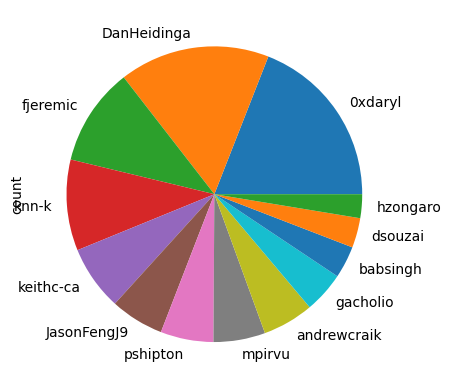

In [59]:
df["assignees"].value_counts().plot(kind = "pie")

In [60]:
len(df)

1538

In [61]:
def encode(df, column_name, sort = False):
    data = list(df[column_name].unique())
    if sorted:
        data = sorted(data)
                      
    label2idx = {label: idx for idx, label in enumerate(data)}
    idx2label = { idx: label for idx, label in enumerate(label2idx)}

    return label2idx, idx2label

In [62]:
label2idx, idx2label = encode(df, "label", True)
comp2idx, idx2comp = encode(df, "component", True)
assignee2idx, idx2assignee = encode(df, "assignees", False)

In [63]:
len(df)

1538

In [64]:
def encode_column(x):
    x["label"] = label2idx[str(x["label"])]
    x["component"] = comp2idx[str(x["component"])]
    x["assignees"] = assignee2idx[str(x["assignees"])]

    return x

In [65]:
df = df.apply(encode_column, axis=1)

df.head()

,label,component,assignees
16,26,6,1
21,21,6,1
51,23,0,1
55,21,6,1
57,21,6,9


In [144]:
class DevClassifier(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.2),
            nn.Linear(64, output),
            nn.ReLU(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [153]:
df.to_csv("dev.csv", index=False)

In [145]:
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=22),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1230 154 154


/home/mdafifal.mamun/miniconda3/envs/triagerx/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [146]:
df_train[["label", "component"]]

,label,component
10155,5,3
10566,0,3
4531,4,3
5171,2,3
2952,9,6
...,...,...
7735,30,6
920,5,6
14537,9,3
7634,30,6


In [147]:
len(df["assignees"].unique())

13

In [148]:
model = DevClassifier(1, len(df["assignees"].unique())).cuda()

In [149]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [150]:
import torch.nn.functional as F

In [151]:
# Training loop with validation
batch_size = 20
epochs = 1000

for epoch in range(epochs):
    # Training
    model.train()
    for i in range(0, len(df_train), batch_size):
        inputs = torch.tensor(df_train[i:i+batch_size][["component"]].to_numpy()).cuda()
        labels = torch.tensor(df_train[i:i+batch_size][["assignees"]].to_numpy()).cuda()
        optimizer.zero_grad()
        outputs = model(inputs.to(torch.float32))
        # print(outputs)
        # print(labels.squeeze(1))
        loss = criterion(outputs, labels.squeeze(1))
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(torch.tensor(df_val[["component"]].to_numpy()).cuda().to(torch.float32))
        val_loss = criterion(val_outputs, torch.tensor(df_val[["assignees"]].to_numpy()).cuda().squeeze(1))
        val_predictions = torch.argmax(val_outputs, dim=1)
        # print(val_predictions)
        # print(torch.tensor(df_val[["assignees"]].to_numpy()).cuda().long())
        accuracy = torch.sum(val_predictions == torch.tensor(df_val[["assignees"]].to_numpy()).cuda().long()).item() / len(df_val)

    # Print training and validation metrics
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {accuracy}')


Epoch [1/1000], Training Loss: 2.6165530681610107, Validation Loss: 2.5049033164978027, Validation Accuracy: 15.922077922077921
Epoch [2/1000], Training Loss: 2.536149740219116, Validation Loss: 2.513350486755371, Validation Accuracy: 16.0
Epoch [3/1000], Training Loss: 2.5581142902374268, Validation Loss: 2.5033702850341797, Validation Accuracy: 16.31168831168831
Epoch [4/1000], Training Loss: 2.79671311378479, Validation Loss: 2.5036749839782715, Validation Accuracy: 16.31168831168831
Epoch [5/1000], Training Loss: 2.529755115509033, Validation Loss: 2.492189884185791, Validation Accuracy: 16.31168831168831
Epoch [6/1000], Training Loss: 2.4740822315216064, Validation Loss: 2.4832732677459717, Validation Accuracy: 16.31168831168831
Epoch [7/1000], Training Loss: 2.6628174781799316, Validation Loss: 2.484160900115967, Validation Accuracy: 16.31168831168831
Epoch [8/1000], Training Loss: 2.4787094593048096, Validation Loss: 2.4741721153259277, Validation Accuracy: 16.31168831168831
Epo

Epoch [10/1000], Training Loss: 2.30086350440979, Validation Loss: 2.4628005027770996, Validation Accuracy: 16.31168831168831
Epoch [11/1000], Training Loss: 2.603633165359497, Validation Loss: 2.4586119651794434, Validation Accuracy: 16.31168831168831
Epoch [12/1000], Training Loss: 2.3802905082702637, Validation Loss: 2.4459846019744873, Validation Accuracy: 24.935064935064936
Epoch [13/1000], Training Loss: 2.4583873748779297, Validation Loss: 2.446422576904297, Validation Accuracy: 16.31168831168831
Epoch [14/1000], Training Loss: 2.4378774166107178, Validation Loss: 2.4400293827056885, Validation Accuracy: 16.31168831168831
Epoch [15/1000], Training Loss: 2.491288661956787, Validation Loss: 2.4303770065307617, Validation Accuracy: 24.935064935064936
Epoch [16/1000], Training Loss: 2.630463123321533, Validation Loss: 2.4274842739105225, Validation Accuracy: 24.935064935064936
Epoch [17/1000], Training Loss: 2.5584938526153564, Validation Loss: 2.4209516048431396, Validation Accurac

KeyboardInterrupt: 

In [167]:
# plt.scatter(df["label"], df["assignees"], c = "green")
sns.scatterplot(data=df, x='component', y='assignees', size='Count')
# plt.xticks(rotation=90)
# plt.show()

ValueError: Could not interpret value `Count` for `size`. An entry with this name does not appear in `data`.